In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import imutils 
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data_dir = 'data'
augmented_dir = 'augmented_images'

In [ ]:
# Image Augmentation Function
def augment_images(input_dir, output_dir, n_augmentations):
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Setup data generator
    data_gen = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range=0.1, 
        brightness_range=(0.3, 1.0),
        horizontal_flip=True, 
        vertical_flip=True, 
        fill_mode='nearest'
    )
    
    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        # Read image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
        
        # Reshape image for augmentation
        image = image.reshape((1,) + image.shape)
        
        # Generate augmented images
        i = 0
        for batch in data_gen.flow(image, batch_size=1, 
                                   save_to_dir=output_dir, 
                                   save_prefix='aug_' + filename.split('.')[0], 
                                   save_format='jpg'):
            i += 1
            if i >= n_augmentations:
                break


In [ ]:
# Augment images for each class
augment_images(
    input_dir=os.path.join(data_dir, 'yes'), 
    output_dir=os.path.join(augmented_dir, 'yes'), 
    n_augmentations=10  
)

augment_images(
    input_dir=os.path.join(data_dir, 'no'), 
    output_dir=os.path.join(augmented_dir, 'no'), 
    n_augmentations=14  
)

In [6]:
# Count and print augmented images
augmented_counts = {}
for class_dir in ['yes', 'no']:
    path = os.path.join(augmented_dir, class_dir)
    augmented_counts[class_dir] = len(os.listdir(path))

print("Augmented Image Counts:")
print(augmented_counts)

Augmented Image Counts:
{'yes': 1549, 'no': 1372}


In [7]:
def crop_brain_contour(image):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Crop new image out of the original image using the four extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image


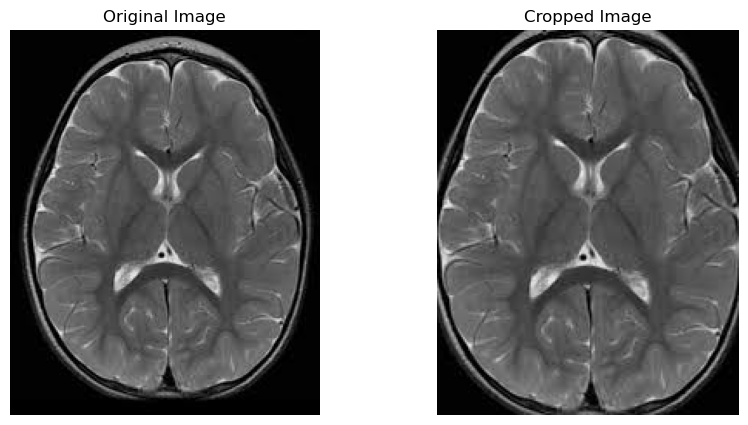

In [8]:
#visualize
image = cv2.imread('data/no/4 no.jpg')
cropped_image = crop_brain_contour(image)
# Plot original and cropped images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Cropped Image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image')
plt.axis('off')
plt.show()


In [9]:
def load_and_preprocess_data(augmented_dir, img_size=(128,128)):
    X = []
    y = []
    
    # Process both classes
    for label, class_dir in enumerate(['no', 'yes']):
        class_path = os.path.join(augmented_dir, class_dir)
        
        for filename in os.listdir(class_path):
            # Read image
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path)
            
            # Crop brain contour
            image = crop_brain_contour(image)
            
            # Resize image
            image = cv2.resize(image, img_size, interpolation=cv2.INTER_CUBIC)
            
            # Normalize pixel values
            image = image / 255.0
            
            X.append(image)
            y.append(label)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y, random_state=42)
    
    return X, y

In [10]:
X, y = load_and_preprocess_data(augmented_dir)

In [11]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [12]:
# Print dataset information
print("Dataset Sizes:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Dataset Sizes:
Training set: 1752 images
Validation set: 584 images
Test set: 585 images


In [13]:
#Visualization of processed images
def plot_sample_images(X, y, title):
    plt.figure(figsize=(15, 5))
    for label in [0, 1]:
        # Get images for each label
        label_images = X[y == label]
        
        # Plot first 5 images for each label
        for i in range(min(5, len(label_images))):
            plt.subplot(2, 5, label * 5 + i + 1)
            plt.imshow(label_images[i])
            plt.title(f"{'Healthy' if label == 0 else 'Tumor'}")
            plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


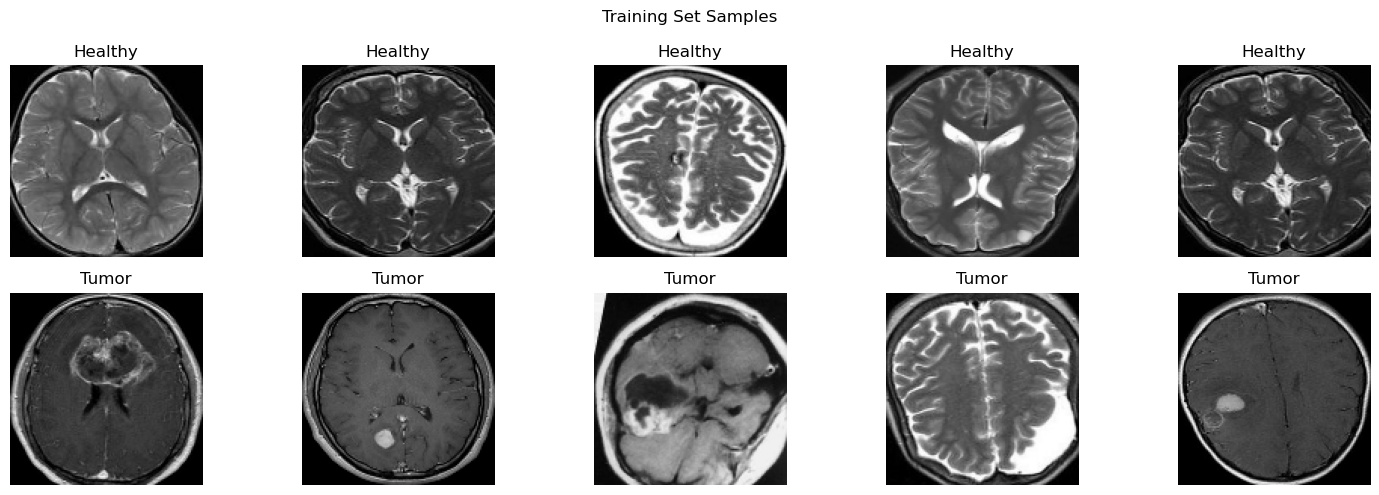

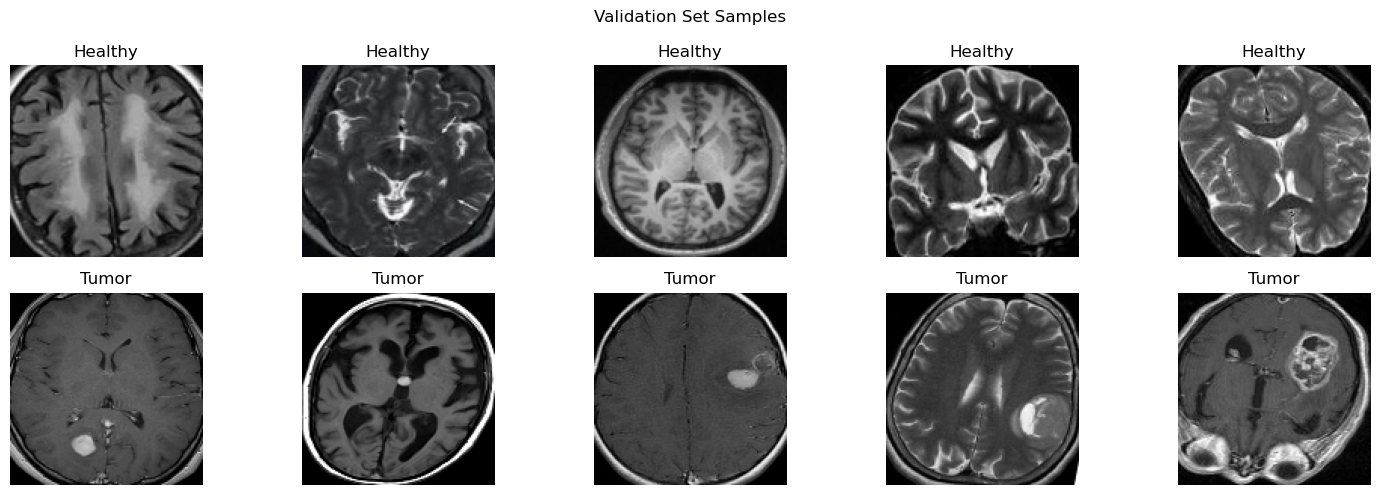

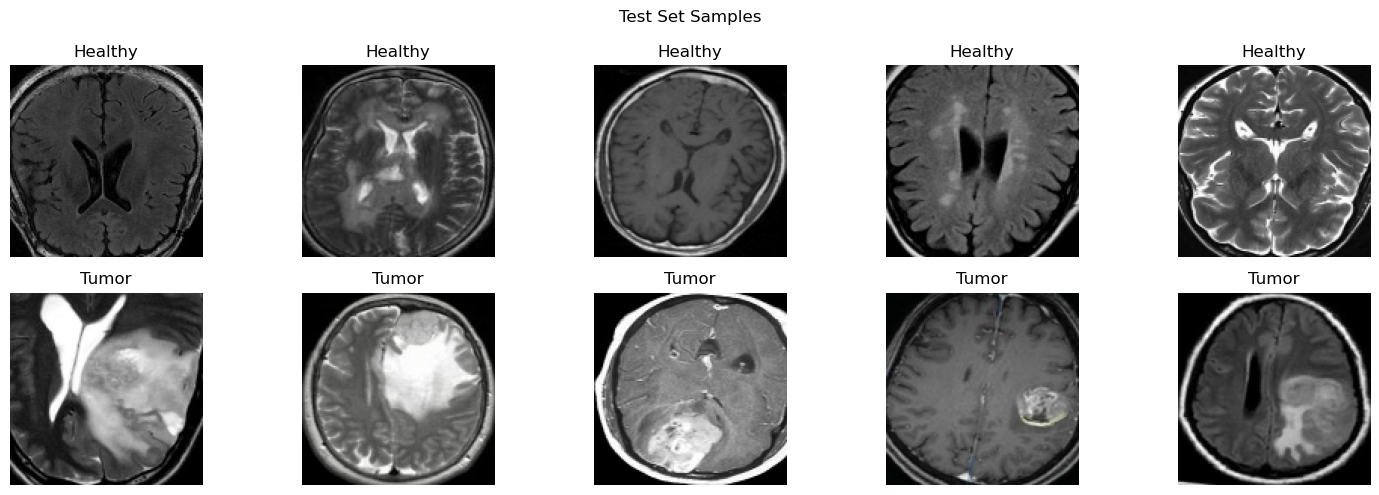

In [14]:
# Visualize processed images
plot_sample_images(X_train, y_train, "Training Set Samples")
plot_sample_images(X_val, y_val, "Validation Set Samples")
plot_sample_images(X_test, y_test, "Test Set Samples")

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)


base_model = VGG16(input_shape=(128, 128, 3), include_top=False)


for layer in base_model.layers:
    layer.trainable = False

X = Flatten()(base_model.output)



X = Dense(units=128, activation='relu')(X)
X = Dropout(0.3)(X)  # .3 dropout rate
X = Dense(units=1, activation='sigmoid')(X)

# Create the  model
model = Model(inputs=base_model.input, outputs=X)


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
)

In [19]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Get final accuracies from the history
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6561 - loss: 0.7086 - val_accuracy: 0.8990 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8969 - loss: 0.2662 - val_accuracy: 0.9264 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9307 - loss: 0.1897 - val_accuracy: 0.9264 - val_loss: 0.1778 - learning_rate: 0.0010
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9566 - loss: 0.1378 - val_accuracy: 0.9298 - val_loss: 0.1820 - learning_rate: 0.0010
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.9587 - loss: 0.1110 - val_accuracy: 0.9623 - val_loss: 0.1034 - learning_rate: 0.0010
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9837 - loss: 0.0665 - val_accuracy: 0.9726 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9847 - loss: 0.0547 - val_accu

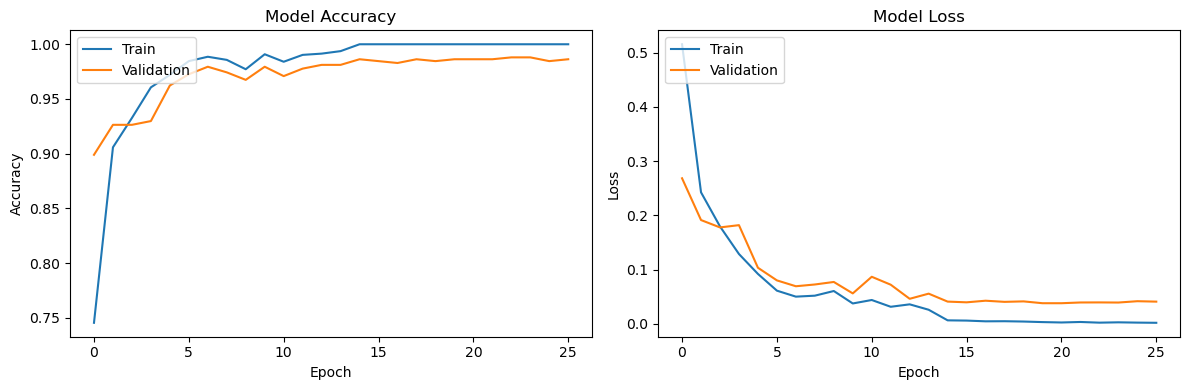

In [20]:
# Plotting training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9950 - loss: 0.0246

Test Accuracy: 0.9915


19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-score   support

    No Tumor       0.99      0.99      0.99       275
       Tumor       0.99      0.99      0.99       310

    accuracy                           0.99       585
   macro avg       0.99      0.99      0.99       585
weighted avg       0.99      0.99      0.99       585



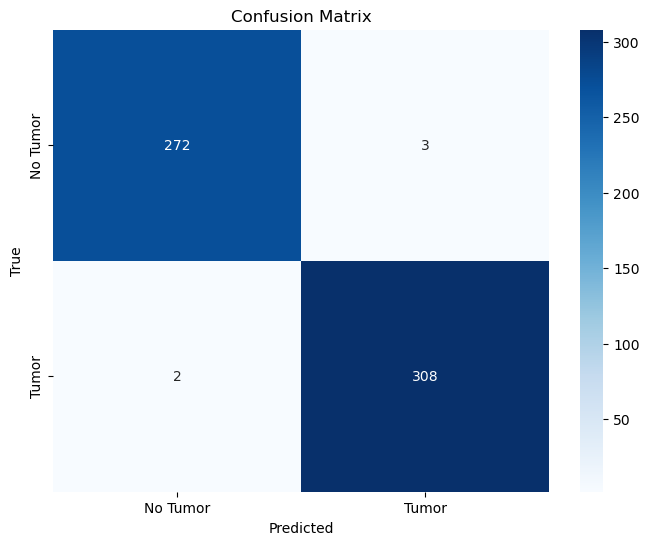

In [22]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary class labels (0 or 1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the classification report (includes precision, recall, and F1-score)
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [25]:
# Save the model to an HDF5 file
model.save('brain_tumor_model.h5')
